# **Project - Sentimental Analysis on IMDB Movie Reviews Dataset**

In [68]:
# Imports
import re
import numpy as np
from os import listdir
from collections import Counter
import spacy
from random import shuffle
import pandas as pd
from matplotlib import pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

nlp = spacy.load("en_core_web_sm")

# Drive root dir for data files
drive_root = '/content/drive/MyDrive/NLP-In-Depth/Develop Deep Learning Models for Natural Language in Python/Data/txt_sentoken'

## Data PrePreprocessing 

### Feature Extraction - Load & Clean

In [2]:
def load_doc(path):
  ''' Loads a document given its path and returns the content '''

  with open(path, 'r') as reader:
    doc = reader.read()
  return doc


def clean_doc(doc):
  ''' Returns the cleaned form of a given doc '''

  doc = nlp(doc)

  # Filter punctuations, stopwords and lemmatize
  doc = ' '.join([token.lemma_ for token in doc if (not token.is_punct) and (not token.is_stop)])

  # Filter non-alphabetic, one-characters
  tokens = [word for word in doc.split(' ') if word.isalpha() and len(word) > 1]

  return tokens


def load_docs(root_dir, sub_folder, vocab):
  ''' Loads all the documents within the path and returns the cleaned form '''

  dir = root_dir + '/' + sub_folder
  docs = []

  for filename in listdir(dir):

    print(f'Processing {sub_folder} document \'{filename}\'...')

    # Load doc
    doc = load_doc(dir + '/' + filename)

    # Clean doc
    tokens = clean_doc(doc)

    # Update vocabulary
    vocab.update(tokens)

    # Add to docs
    docs.append(' '.join(tokens))    

  return docs

In [3]:
# Construct counter object
vocab = Counter()

# Load positive reviews
pos_docs = load_docs(drive_root, 'pos', vocab)

# Load negative reviews
neg_docs = load_docs(drive_root, 'neg', vocab)

print('Vocab size:', len(vocab))
print('50 Most common words:', vocab.most_common(50))

Processing pos document 'cv000_29590.txt'...
Processing pos document 'cv001_18431.txt'...
Processing pos document 'cv002_15918.txt'...
Processing pos document 'cv003_11664.txt'...
Processing pos document 'cv004_11636.txt'...
Processing pos document 'cv005_29443.txt'...
Processing pos document 'cv006_15448.txt'...
Processing pos document 'cv007_4968.txt'...
Processing pos document 'cv008_29435.txt'...
Processing pos document 'cv009_29592.txt'...
Processing pos document 'cv010_29198.txt'...
Processing pos document 'cv011_12166.txt'...
Processing pos document 'cv012_29576.txt'...
Processing pos document 'cv013_10159.txt'...
Processing pos document 'cv014_13924.txt'...
Processing pos document 'cv015_29439.txt'...
Processing pos document 'cv016_4659.txt'...
Processing pos document 'cv017_22464.txt'...
Processing pos document 'cv018_20137.txt'...
Processing pos document 'cv019_14482.txt'...
Processing pos document 'cv020_8825.txt'...
Processing pos document 'cv021_15838.txt'...
Processing po

### More Work on Vocab

In [4]:
def filter_docs(docs, vocab_words):
  ''' Filters tokens in given text by vocabulary '''

  for i in range(len(docs)):
    docs[i] = ' '.join([token for token in docs[i].split(' ') if token in vocab_words])
  return docs


# Remove least frequently used words
min_occurance = 2
vocab_words = [key for key, count in vocab.items() if count >= min_occurance]

# Fitler docs
pos_docs = filter_docs(pos_docs, vocab_words)
neg_docs = filter_docs(neg_docs, vocab_words)

### Save Cleaned Docs & Vocab

In [5]:
# Save Vocab for future use
with open(drive_root + '/vocab.txt', 'w') as writer:
  writer.write('\n'.join(vocab_words))

# Save positive docs
with open(drive_root + '/pos.txt', 'w') as writer:
  writer.write('\n'.join(pos_docs))

# Save negative docs
with open(drive_root + '/neg.txt', 'w') as writer:
  writer.write('\n'.join(neg_docs))

## Building Models

### Load saved data

In [6]:
# Save Vocab for future use
with open(drive_root + '/vocab.txt', 'r') as reader:
  vocab_words = reader.read().split('\n')

# Save positive docs
with open(drive_root + '/pos.txt', 'r') as reader:
  pos_docs = reader.read().split('\n')

# Save negative docs
with open(drive_root + '/neg.txt', 'r') as reader:
  neg_docs = reader.read().split('\n')

### Split data

In [18]:
def split(pos_docs, neg_docs, test_size = 200):
  ''' Splits the docs into training and test sets '''

  split = test_size // 2

  # Unite pos_docs & neg_docs and corresponding labels
  docs = pos_docs + neg_docs
  labels = [1 for _ in range(len(pos_docs))] + [0 for _ in range(len(neg_docs))]

  # Convert into tuple
  data = [(docs[i], labels[i]) for i in range(len(docs))]

  # Split data into train & test sets
  train_data = data[split:-split]
  test_data = data[:split] + data[-split:]

  # Shuffle data
  shuffle(train_data)
  shuffle(test_data)

  return train_data, test_data

train_data, test_data = split(pos_docs, neg_docs, test_size = 200)

### Prepare data

In [19]:
def prepare_data(vocab_words, train_data, test_data, mode):
  ''' Creates, fits and returns a tokenizer '''

  # Create tokenizer
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(vocab_words)

  # Get texts
  train_texts = [text for (text, label) in train_data]
  test_texts = [text for (text, label) in test_data]

  # Get labels
  y_train = np.array([label for (text, label) in train_data])
  y_test = np.array([label for (text, label) in test_data])

  X_train = tokenizer.texts_to_matrix(train_texts, mode = mode)
  X_test = tokenizer.texts_to_matrix(test_texts, mode = mode)

  return X_train, y_train, X_test, y_test, tokenizer

### Build & Evaluate the Model

In [120]:
def build_model(X_train, y_train):
  ''' Build and trains a model '''

  model = Sequential()

  input_shape = X_train.shape[1]

  # Add layers
  model.add(Dense(units = 50, input_shape = (input_shape, ), activation = 'relu'))
  model.add(Dense(units = 1, activation = 'sigmoid'))

  # Compile and summerize
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  # model.summary()
  # plot_model(model, show_shapes = True)

  # Fit the model
  history = model.fit(X_train, y_train, epochs = 10, verbose = 0, validation_split = 0.1, batch_size = 16)

  return model, history 


def evaluate_model(model, X_test, y_test):
  ''' Evaluates the given model '''  

  # Evaluate Model
  loss, acc = model.evaluate(X_test, y_test, verbose = 0)  

  return loss, acc

In [122]:
# Tokenization modes
modes = ['binary', 'count', 'freq', 'tfidf']

# Construct raw dataframe
evaluation_results = pd.DataFrame()

for mode in modes:

  # Prepare data
  X_train, y_train, X_test, y_test, tokenizer = prepare_data(vocab_words, train_data, test_data, mode)
  # print('Dimentions:', X_train.shape, X_test.shape)

  # Build and evaluate model
  model, history = build_model(X_train, y_train)
  loss, acc = evaluate_model(model, X_test, y_test)

  evaluation_results[mode] = [loss, acc]
  print(f'Mode: {mode} - Loss: {round(loss * 100, 2)}, Accuracy: {round(acc * 100, 2)}%')

Mode: binary - Loss: 40.17, Accuracy: 86.5%
Mode: count - Loss: 49.04, Accuracy: 85.5%
Mode: freq - Loss: 42.28, Accuracy: 84.0%
Mode: tfidf - Loss: 54.5, Accuracy: 84.0%


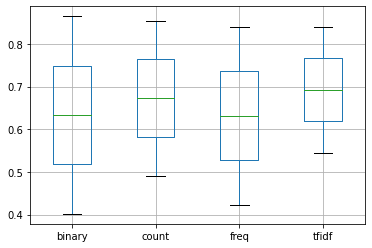

In [123]:
evaluation_results.boxplot()

## Predictions & Sentimental Analysis

In [124]:
def predict_sentiment(review, vocab_words, tokenizer, model):
  ''' Predicts the given review using our trained model '''

  # Clean review & split to tokens
  tokens =  clean_doc(review)

  # Remove words outside vocab
  tokens = [token for token in tokens if token in vocab_words]

  line = ' '.join(tokens)

  # Encode review with binary mode (Top accuracy)
  encoded = tokenizer.texts_to_matrix(line, mode = 'binary')  
  pred = model.predict(encoded, verbose = False)

  percent_pos = pred[0, 0]

  if round(percent_pos) == 0:
    return (1 - percent_pos, 'NEGATIVE')
  else:
    return (percent_pos, 'POSITIVE')

Loss: 39.2, Accuracy: 86.5%


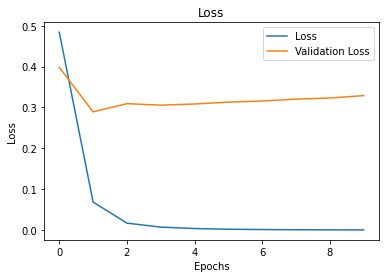

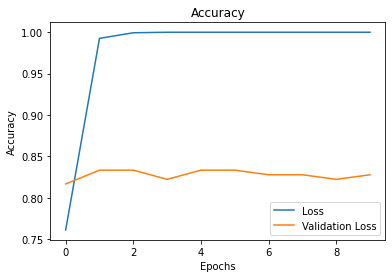

In [129]:
# Build best model
X_train, y_train, X_test, y_test, tokenizer = prepare_data(vocab_words, train_data, test_data, 'binary')
model, history = build_model(X_train, y_train)
loss, acc = evaluate_model(model, X_test, y_test)
print(f'Loss: {round(loss * 100, 2)}, Accuracy: {round(acc * 100, 2)}%')

# Loss
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label = 'Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

# Accuracy
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label = 'Loss')
plt.plot(history.history['val_accuracy'], label = 'Validation Loss')
plt.legend()
plt.show()

In [130]:
# Make a predictions
review = 'Worst movie ever I really hate it '
percent, label = predict_sentiment(review, vocab_words, tokenizer, model)
print(f'{label} ({round(percent * 100, 3)}%)')

review = 'This was a bad terrible movie.'
percent, label = predict_sentiment(review, vocab_words, tokenizer, model)
print(f'{label} ({round(percent * 100, 3)}%)')

review = 'good, I recommend it! Best movie I have ever seen'
percent, label = predict_sentiment(review, vocab_words, tokenizer, model)
print(f'{label} ({round(percent * 100, 3)}%)')

NEGATIVE (56.177%)
NEGATIVE (56.177%)
NEGATIVE (56.177%)
